In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jax.example_libraries.optimizers import adam as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 10
NN_SHAPES = jnp.array([64, 64, 64])
SCALE = 0.01
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
STEP_SIZE = 1e-1

BETA = 0.9
MAX_AGE = 2.
OBJECTIVE_FN = lambda x, t: jax.lax.select(t == 2., 
                                           jnp.array([jnp.log(x), x]), 
                                           jax.lax.select(t == 1., 
                                                          jnp.array([jnp.log(x / (1 + BETA)) + BETA * jnp.log((BETA * x) / (1 + BETA)), (x / (1 + BETA))]), 
                                                          jnp.array([(1 + BETA + BETA**2) * jnp.log(x) - (1 + BETA + BETA **2) * jnp.log(1 + BETA + BETA**2) + BETA * (1 + 2 * BETA) * jnp.log(BETA),
                                                                     x / (1 + BETA + BETA**2)])))

In [3]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(2, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
w2 = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1] + 2, NN_SHAPES[2]))
wf = SCALE * jax.random.normal(INIT_KEYS[3], shape=(NN_SHAPES[2],))
b0 = SCALE * jax.random.normal(INIT_KEYS[4], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, NN_SHAPES[1]))
b2 = SCALE * jax.random.normal(INIT_KEYS[6], shape=(1, NN_SHAPES[2]))
bf = SCALE * jax.random.normal(INIT_KEYS[7], shape=(1,))
params0 = {'w0': w0, 'w1': w1, 'vw2': w2, 'cw2': w2, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'vb2': b2, 'cb2': b2, 'vbf': bf, 'cbf': bf}

In [74]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e6)


@jax.jit
def neural_network(params, x, t):
    l0 = jnp.concatenate((x[jnp.newaxis], t[jnp.newaxis]))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    
    vl3 = relu(jnp.concatenate((l0, l2)), params['vw2'], params['vb2'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select(t[jnp.newaxis] > MAX_AGE, jnp.zeros(1), vu)
    
    cl3 = relu(jnp.concatenate((l0, l2)), params['cw2'], params['cb2'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select(t[jnp.newaxis] >= MAX_AGE, x[jnp.newaxis], cu)
    
    return jnp.concatenate((v, c))


@jax.jit
def loss(params, x, t):
    v0, c0 = neural_network(params, x, t)
    v1, c1 = neural_network(params, x - c0, t + 1)
    v1x = jax.grad(lambda x: neural_network(params, x, t + 1)[0])(x - c0)
    
    live_next = (t < MAX_AGE)
    loss_euler = jax.lax.select(live_next, (c1 - (BETA * c0)), 0.)
    loss_envelope = BETA * v1x * c0 - 1
    loss_bellman = (jnp.log(c0) + BETA * v1) - v0
    
    return jnp.array([loss_euler, loss_envelope, loss_bellman])


@jax.tree_util.Partial(jax.jit, static_argnums=(4,))
def batch_loss(params, xs, ts, W, gmm=False):
    losses = jax.vmap(loss, in_axes=(None, 0, 0))(params, xs, ts)
    W_new = jnp.linalg.inv(jnp.cov(losses.T)) if gmm else jnp.eye(3) # jnp.diag(jnp.array([1e1, 1e-1, 1.]))
    return jnp.mean(jax.vmap(lambda l: l @ W @ l.T)(losses)), W_new

In [77]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jnp.concatenate((jnp.zeros(1000), jnp.ones(1000)))

def training_loop(X, T, opt_state, opt_update, get_params, gmm=False, max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    W = jnp.eye(3)
    
    best_opt_state = opt_state
    best_loss, _ = batch_loss(get_params(best_opt_state), all_X, all_T, W, gmm=gmm)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (2, MB))
        params = get_params(opt_state)

        out, grad = jax.value_and_grad(batch_loss, has_aux=True)(params, X[sample[0]], T[sample[1]], W, gmm=gmm)
        val_loss = out[0]
        # if j % 100 == 0:
        W = out[1]
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            print(W)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j % 100 == 0:
            fair_loss, _ = batch_loss(params, all_X, all_T, jnp.eye(3), gmm=gmm)
            if fair_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.4f}\tFair Loss: {fair_loss:.4f}')
        j += 1
            
    return opt_state, best_opt_state

In [6]:
opt_init, opt_update, get_params = optimizer(step_size=STEP_SIZE)
opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))
if not 'best_opt_state' in globals():
    best_opt_state = opt_state

current_opt_state, best_opt_state = training_loop(X, T, best_opt_state, opt_update, get_params, gmm=False, max_iter=2000)

Iteration: 0	Current Loss: 4.2808	Fair Loss: 4.9738
Iteration: 100	Current Loss: 0.7161	Fair Loss: 0.5612
Iteration: 200	Current Loss: 0.7468	Fair Loss: 0.4964
Iteration: 300	Current Loss: 0.7829	Fair Loss: 0.4748
Iteration: 400	Current Loss: 0.5597	Fair Loss: 0.3774
Iteration: 500	Current Loss: 0.6532	Fair Loss: 0.4232
Iteration: 600	Current Loss: 0.6310	Fair Loss: 0.3019
Iteration: 700	Current Loss: 0.5166	Fair Loss: 0.2355
Iteration: 800	Current Loss: 0.4362	Fair Loss: 0.1711
Iteration: 900	Current Loss: 0.4909	Fair Loss: 0.1859
Iteration: 1000	Current Loss: 0.4301	Fair Loss: 0.1520
Iteration: 1100	Current Loss: 0.4349	Fair Loss: 0.1716
Iteration: 1200	Current Loss: 0.4921	Fair Loss: 0.1761
Iteration: 1300	Current Loss: 0.4191	Fair Loss: 0.1130
Iteration: 1400	Current Loss: 0.4212	Fair Loss: 0.1035
Iteration: 1500	Current Loss: 0.4334	Fair Loss: 0.0730
Iteration: 1600	Current Loss: 0.3583	Fair Loss: 0.0585
Iteration: 1700	Current Loss: 0.4122	Fair Loss: 0.0726
Iteration: 1800	Curren

<AxesSubplot:xlabel='0'>

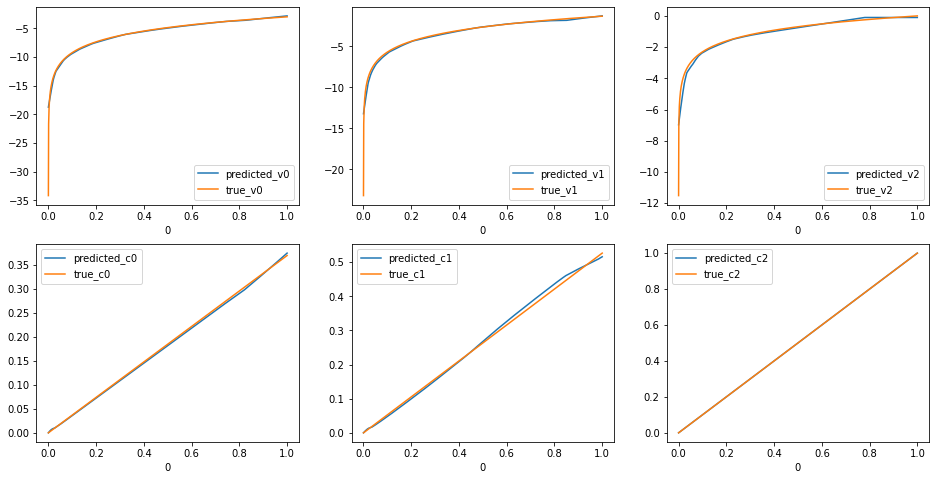

In [7]:
params = get_params(best_opt_state)
init0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 0.)
pred0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 0.)
true0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 0.)

init1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 1.)
pred1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 1.)
true1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 1.)

init2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 2.)
pred2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 2.)
true2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 2.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init0, pred0, true0, 
                                   init1, pred1, true1,
                                   init2, pred2, true2), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v0', 'initial_c0', 'predicted_v0', 'predicted_c0', 'true_v0', 'true_c0',
              'initial_v1', 'initial_c1', 'predicted_v1', 'predicted_c1', 'true_v1', 'true_c1',
              'initial_v2', 'initial_c2', 'predicted_v2', 'predicted_c2', 'true_v2', 'true_c2']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
df.plot(y=['predicted_v0', 'true_v0'], ax=axes.flatten()[0])
df.plot(y=['predicted_v1', 'true_v1'], ax=axes.flatten()[1])
df.plot(y=['predicted_v2', 'true_v2'], ax=axes.flatten()[2])
df.plot(y=['predicted_c0', 'true_c0'], ax=axes.flatten()[3])
df.plot(y=['predicted_c1', 'true_c1'], ax=axes.flatten()[4])
df.plot(y=['predicted_c2', 'true_c2'], ax=axes.flatten()[5])

In [80]:
opt_init, opt_update, get_params = optimizer(step_size=1e-2)
opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))

current_opt_state, best_opt_state = training_loop(X, T, best_opt_state, opt_update, get_params, gmm=True, max_iter=2000)

Iteration: 0	Current Loss: 3.7562	Fair Loss: 1.0694
Iteration: 100	Current Loss: 4.8629	Fair Loss: 1.1080
Iteration: 200	Current Loss: 4.7625	Fair Loss: 1.1029
Iteration: 300	Current Loss: 4.7788	Fair Loss: 1.0861
Iteration: 400	Current Loss: 4.1576	Fair Loss: 1.0856
Iteration: 500	Current Loss: 4.6418	Fair Loss: 1.0632
Iteration: 600	Current Loss: 4.7431	Fair Loss: 1.0669
Iteration: 700	Current Loss: 7.9983	Fair Loss: 1.0923
Iteration: 800	Current Loss: 4.5188	Fair Loss: 1.0983
Iteration: 900	Current Loss: 4.3833	Fair Loss: 1.0861
Iteration: 1000	Current Loss: 4.4554	Fair Loss: 1.0755
Iteration: 1100	Current Loss: 4.3100	Fair Loss: 1.0790
Iteration: 1200	Current Loss: 4.2943	Fair Loss: 1.0615
Iteration: 1300	Current Loss: 5.2653	Fair Loss: 1.1055
Iteration: 1400	Current Loss: 4.2644	Fair Loss: 1.0944
Iteration: 1500	Current Loss: 5.4007	Fair Loss: 1.1650
Iteration: 1600	Current Loss: 4.2736	Fair Loss: 1.1073
Iteration: 1700	Current Loss: 5.0680	Fair Loss: 1.0662
Iteration: 1800	Curren

<AxesSubplot:xlabel='0'>

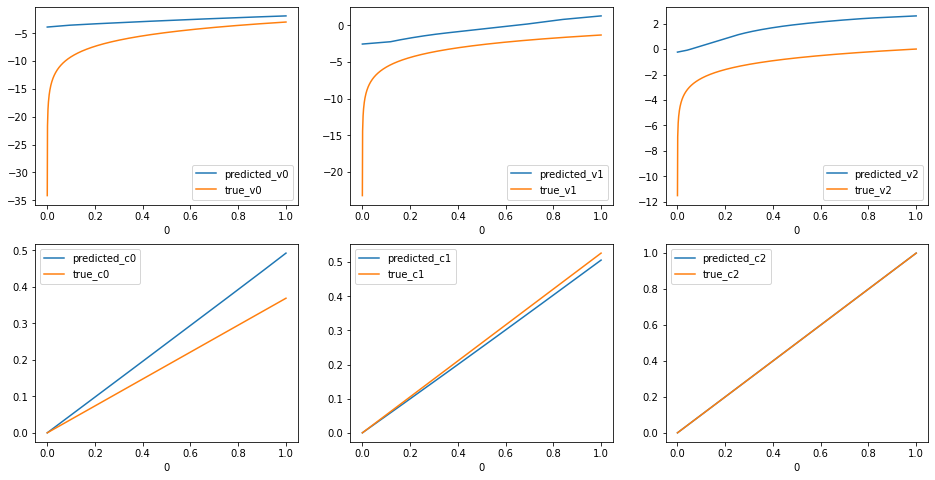

In [81]:
params = get_params(best_opt_state)
init0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 0.)
pred0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 0.)
true0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 0.)

init1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 1.)
pred1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 1.)
true1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 1.)

init2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 2.)
pred2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 2.)
true2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 2.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init0, pred0, true0, 
                                   init1, pred1, true1,
                                   init2, pred2, true2), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v0', 'initial_c0', 'predicted_v0', 'predicted_c0', 'true_v0', 'true_c0',
              'initial_v1', 'initial_c1', 'predicted_v1', 'predicted_c1', 'true_v1', 'true_c1',
              'initial_v2', 'initial_c2', 'predicted_v2', 'predicted_c2', 'true_v2', 'true_c2']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
df.plot(y=['predicted_v0', 'true_v0'], ax=axes.flatten()[0])
df.plot(y=['predicted_v1', 'true_v1'], ax=axes.flatten()[1])
df.plot(y=['predicted_v2', 'true_v2'], ax=axes.flatten()[2])
df.plot(y=['predicted_c0', 'true_c0'], ax=axes.flatten()[3])
df.plot(y=['predicted_c1', 'true_c1'], ax=axes.flatten()[4])
df.plot(y=['predicted_c2', 'true_c2'], ax=axes.flatten()[5])

In [85]:
losses = jax.vmap(loss, in_axes=(None, 0, 0))(get_params(best_opt_state), all_X, all_T)
jnp.mean(losses**2, axis=0)

DeviceArray([0.00620686, 0.1800749 , 0.85941666], dtype=float32)

In [83]:
l, W = batch_loss(get_params(best_opt_state), all_X, all_T, jnp.eye(3), gmm=True)
lw, _ = batch_loss(get_params(best_opt_state), all_X, all_T, W, gmm=True)
print(l)
print(lw)
print(W)

1.0456984
3.5779192
[[ 2.38232483e+02  1.58836651e+01  2.97809839e-02]
 [ 1.58836775e+01  2.24951172e+01 -8.38889027e+00]
 [ 2.97866520e-02 -8.38888931e+00  4.58278036e+00]]


In [ ]:
losses = jax.vmap(loss, in_axes=(None, 0, 0))(get_params(current_opt_state), all_X, all_T)
preds = jax.vmap(lambda x, t: neural_network(get_params(current_opt_state), x, t))(all_X, all_T)
preds[jnp.where(preds[:, 1] <= 0.)]